# DS 2500 HW 5

In [1]:
import pandas as pd

df_boston = pd.read_csv("boston_houses.csv", index_col = None)
df_boston.head()

,beds,baths,area,distance,price,price_bucket
0,3.0,2.0,2584.0,18.726140,1100000.0,price >= 900k
1,1.0,1.0,650.0,1.053808,699000.0,600k <= price < 900k
2,2.0,3.0,1794.0,0.471038,1750000.0,price >= 900k
3,4.0,3.0,1831.0,3.611435,979000.0,price >= 900k
4,3.0,3.0,1875.0,2.200608,1875000.0,price >= 900k


# Part 1: Decision Tree Classifier (21 points)

In [2]:
df_boston["price_bucket"].value_counts()

price < 600k            321
price >= 900k           320
600k <= price < 900k    313
Name: price_bucket, dtype: int64

In [3]:
import matplotlib.pyplot as plt
from sklearn import tree

def train_dec_tree_price(df_boston, max_depth = 2, x_feat_list = None, plot = True):
    """ trains a decision tree classifier, optionally prints graph
    
    Args:
        df_boston (pd.DataFrame): boston property prices
        max_depth (int): max depth of decision tree
        x_feat_list (list): list of input features
        plot (bool): toggles graph output (default: True)
        
    Returns:
        dec_tree_clf (DecisionTreeClassifier): trained decicision tree
        x (pd.DataFrame): input features for each sample
        y (pd.DataFrame): price_bucket for each sample
    """
    # default x-features
    if x_feat_list is None:
        x_feat_list = ["beds", "baths", "area", "distance"]

    # extract data
    x = df_boston.loc[:, x_feat_list].values
    y = df_boston.loc[:, "price_bucket"].values
    
    # build classifier, fit data
    dec_tree_clf = tree.DecisionTreeClassifier(max_depth = max_depth)
    dec_tree_clf.fit(x, y)
    
    # plot decision tree
    class_names = ["600k <= price < 900k", "price < 600k", "price >= 900k"]
    if plot:
        plt.figure()
        plt.gcf().set_size_inches(15, 10)
        tree.plot_tree(dec_tree_clf, feature_names = x_feat_list, class_names = class_names)
    
    return dec_tree_clf, x, y

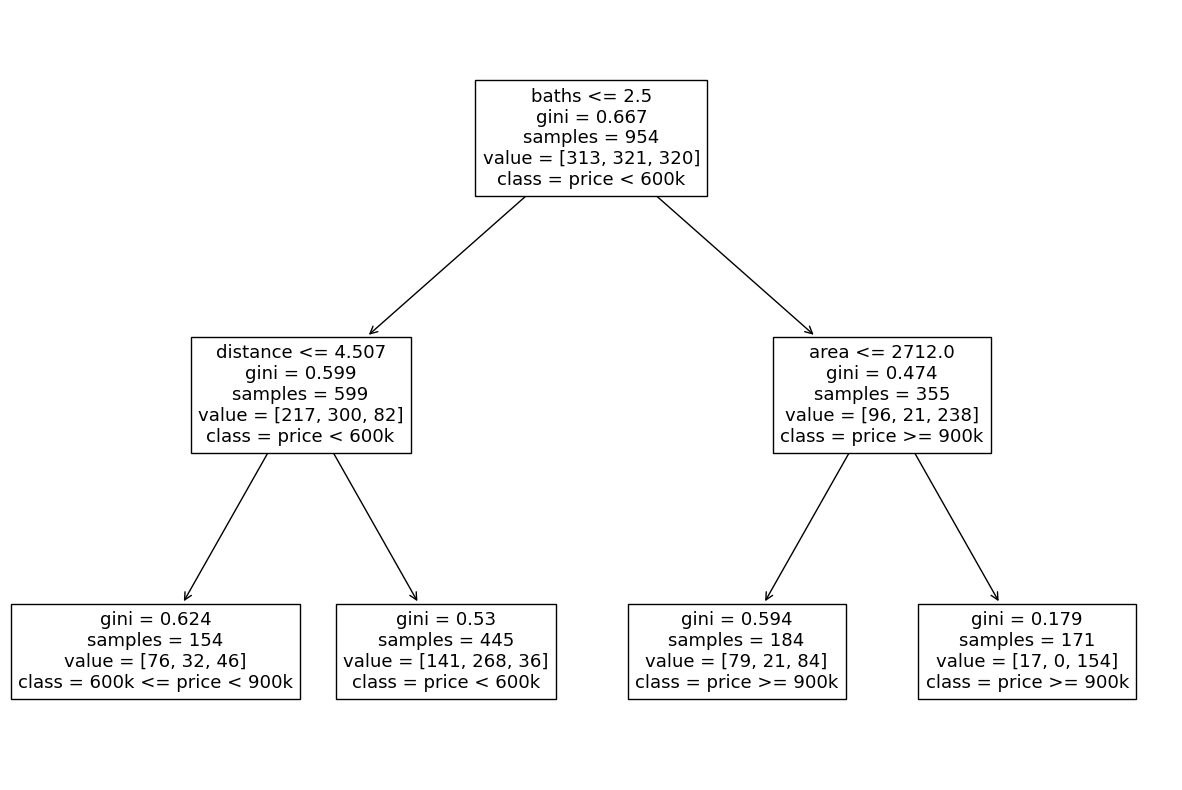

In [4]:
dec_tree, x, y = train_dec_tree_price(df_boston)

*the first step to the right in the decision tree shows that if a certain house has more than 2.5 bathrooms **and** a large floor area, the model can intuitively predict that that house belongs to a price classification of larger that 900k.*

*comparatively, this gini score is the closest to zero, showing that as the machine moves down the decision tree, the samples are similar enough to begin to sort themselves into their respective classes.*

# Part 2: Random Forest Classification (23 points)

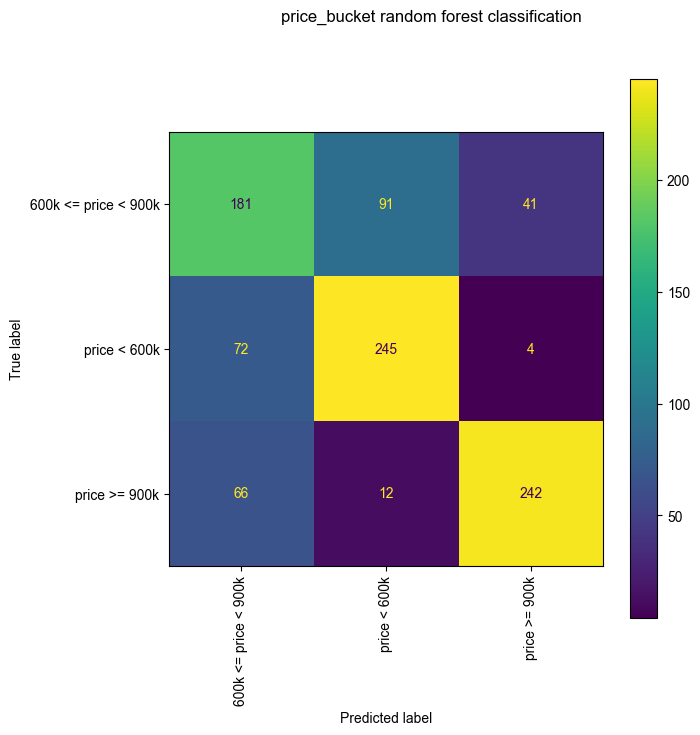

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from copy import copy
import seaborn as sns
import numpy as np

# reload data, initialize kfold and random forest objects
x = x
y_true = y
y_pred = copy(y_true)

kfold = KFold(n_splits = 3, shuffle = True)

rf_clf = RandomForestClassifier(max_depth = 3)
rf_clf.fit(x, y)

# train, test, predict
for train_idx, test_idx in kfold.split(x, y_true):
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]
    
    rf_clf.fit(x_train, y_true_train)
    y_pred[test_idx] = rf_clf.predict(x_test)
    
# plot confusion matrix
conf_mat = confusion_matrix(y_true = y_true, y_pred = y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels = np.unique(y_true))

conf_mat_disp.plot()
plt.suptitle("price_bucket random forest classification")
plt.gcf().set_size_inches(7, 7)
plt.xticks(rotation = 90)
sns.set(font_scale = 2)
plt.grid(False)

In [6]:
from sklearn.metrics import accuracy_score

# compute accuracy
accuracy_score(y_true, y_pred)

0.70020964360587

# Part 3 Feature Importance in Random Forest (16 points)

In [7]:
def plot_feat_import(feat_list, feat_import, sort = True, limit = None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance from top to bottom of plot
        limit (int): if passed, limits the number of features shown to this value    
    """
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import, color = "r", alpha = .7)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel("importance of each feature")
    plt.grid(False)

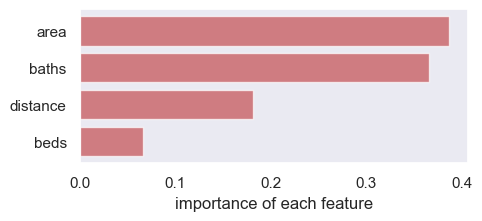

In [8]:
x_feat_list = ["beds", "baths", "area", "distance"]

sns.set()
plot_feat_import(x_feat_list, rf_clf.feature_importances_)

this bar plot shows that the floor area of the house is the largest predictor of its price compared to other features. the plot also shows that the number of bathrooms also has a significant impact on house classification. from this visualization, we can make a strong inference that **home area may be correlated with home price.**

# Part 4: `RandomForestRegressor` and housing prices

## Part 4.1: Compute a cross validated $R^2$ for a `RandomForestRegressor` (9 points)

In [9]:
import pandas as pd

df_house = pd.read_csv('boston_houses.csv', index_col=None)
df_house.head()

,beds,baths,area,distance,price,price_bucket
0,3.0,2.0,2584.0,18.726140,1100000.0,price >= 900k
1,1.0,1.0,650.0,1.053808,699000.0,600k <= price < 900k
2,2.0,3.0,1794.0,0.471038,1750000.0,price >= 900k
3,4.0,3.0,1831.0,3.611435,979000.0,price >= 900k
4,3.0,3.0,1875.0,2.200608,1875000.0,price >= 900k


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# reload data
x = x
y = df_boston.loc[:, "price"].values

# initialize model and fit
rf = RandomForestRegressor()
rf.fit(x, y)

# compute r2 value
y_pred = rf.predict(x)
print(f"r2: {r2_score(y, y_pred)}")

r2: 0.9613553907343165


## Part 4.2. Plot the feature importances of your `RandomForestRegressor` (8 points)

You should update `plot_feat_import()` to properly label the x axis.  (`RandomForestClassifier`s minimize Gini, what do `RandomForestRegressor`s minimize?)

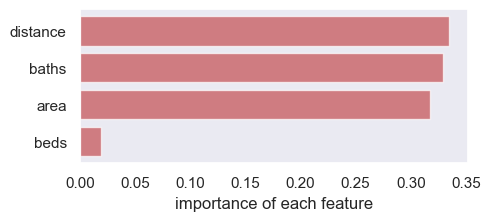

In [11]:
plot_feat_import(x_feat_list, rf.feature_importances_)

# the random forest regression tries to minimize the mean of squared errors

## Part 4.3 Regressor vs Classifier? (7 points) 
Between the `RandomForestRegressor`s and `RandomForestClassifier`, explain which feature importance graph you trust more.

in my opinion, the regression plot seems more trustworthy. it felt more intuitive to fit a model to the data to make a prediction then try to have the data classify itself based on ambiguous parameters. however, both models shows that the features and the home price are strongly correlated.

# Part 5: Ethics of Housing Pricing (16 points)

In the case of predicting housing prices in Boston, we should be mindful of Redlining.  Naively used, this model can propogate and promote racist real estate processes via their influence in future housing prices.

Using the resources listed below, identify two distinct ways in which a biased model (one which overvalues the houses of white people while undervaluing the houses of people of color) might propogate [racism](http://msan.wceruw.org/conferences/2015-studentConf/Defining%20Racism%20by%20Beverly%20Daniel%20Tatum.pdf) if used to predict housing values (e.g. [Zillow](https://www.zillow.com/) or similar).  Please give each of the two impacts its own markdown heading (`###`) and write one to three sentences which characterize it.

- [Wikipedia on Redlining](https://en.wikipedia.org/wiki/Redlining)
- [NPR Video (start here)](https://youtu.be/O5FBJyqfoLM?t=14) 
- [NYTimes article](https://www.nytimes.com/2021/03/20/opinion/home-value-race-taxes.html) 
- [NyTimes article](https://www.nytimes.com/2022/08/18/realestate/housing-discrimination-maryland.html)

### impact one
as stated in the first new york times article, research shows that white people find all-white neighborhoods desireable. economically speaking, this may put upward pressure on homes in certain neighborhoods to discourage certain groups of people from living in that area.

### impact two
despite the already tumultuous process of buying a home, people of color have more to consider, financially speaking. if they choose to live in a diverse neighborhood, the value of their home may not appreciate as much as it could. on the other hand, if they decide to live in a predominantly white neighborhood, they run the risk of feeling like an outsider in their own home.